In [623]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

# default module
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import copy

import datetime
import time 

from sklearn.model_selection import KFold

In [624]:
import warnings
warnings.filterwarnings('ignore')

In [625]:
## utils

def select_important_feautre(columns, feature_importance, num):
    
    #딕셔너리
    dic = {}
    for value in [list(v) for v in zip(columns, feature_importance)]:
        dic[str(value[1])] = value[0] 
    
    #피처 중요도
    f_i = list(feature_importance)
    f_i.sort(reverse=True)
    
    
    #n개 뽑기
    result = []
    for i in range(0, num):
        result.append(dic[str(f_i[i])])
    
    return result

In [626]:
def cross_val_score_custom(model, x, y, cv, dev = 0):
    
    print('\n\n')
    
    result = []
    
    for train_idx, test_idx in cv.split(x):
        
        new_x_train = x.iloc[train_idx, :]
        new_y_train = y.iloc[train_idx]
        
        new_x_test = x.iloc[test_idx, :]
        new_y_test = y.iloc[test_idx]
        
        model.fit(new_x_train, new_y_train)
        
        temp = np.mean(f1_score(new_y_test, model.predict(new_x_test), average=None))
        
        if dev:
            print('dev Mode # : {}'.format(temp))
        
        result.append(temp)
    
    print('\n\n')
    
    return np.mean(result)

In [627]:
def get_oof(model, x_train, y_train, x_test, k):
    
    le = LabelEncoder()
    le.fit(y_train)
    y_train = pd.Series(le.transform(y_train))
    
    oof_train = np.zeros((x_train.shape[0],))
    oof_test = np.zeros((x_test.shape[0],))
    oof_test_skf = np.empty((k, x_test.shape[0]))
    
    for i, (train_idx, test_idx) in enumerate(KFold(n_splits=k).split(x_train)):
        
        print(i, sep=' ')
        
        x_tr = x_train.iloc[train_idx, :]
        y_tr = y_train.iloc[train_idx]
        x_te = x_train.iloc[test_idx, :]
        
        model.fit(x_tr, y_tr)

        oof_train[test_idx] = model.predict(x_te)
        oof_test_skf[i, :] = model.predict(x_test)
    
    # version 1
    # oof_test[:] = np.round(oof_test_skf.mean(axis=0))
    
    # version 2
    oof_test[:] = pd.DataFrame(oof_test_skf).apply(lambda v: v.value_counts().idxmax(), axis=0)
    
    oof_train = [int(v) for v in oof_train]
    oof_train = le.inverse_transform(oof_train)
    
    oof_test = [int(v) for v in oof_test]
    oof_test = le.inverse_transform(oof_test)
    
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [628]:
def remove_outlier(data, percent):
    data = data.copy()
    thres = data.quantile([percent])
    
    for col in data:
        if data[col].dtype == float or data[col].dtype == int:
            data.loc[data[col] > thres[col].values[0], col] = thres[col].values[0]
    
    return data

In [629]:
def show_feature_plot(data, col_name, log = False):

    if log:
        sns.distplot(np.log(data[col_name][data.is_mal == 0] + 1), color='blue')
        sns.distplot(np.log(data[col_name][data.is_mal == 1] + 1), color='red')
    
    else:
        sns.distplot(data[col_name][data.is_mal == 0], color='blue')
        sns.distplot(data[col_name][data.is_mal == 1], color='red')

In [631]:
def feature_engineerings(dataset):
    dataset = dataset.copy()
    
    dataset.AddressOfEntryPoint = np.log(dataset.AddressOfEntryPoint + 1)
    dataset.AddressOfEntryPoint = dataset.AddressOfEntryPoint.map(temp)
    
#     dataset['year'] = dataset.TimeDateStamp.map(get_year)
#     dataset['mon'] = dataset.TimeDateStamp.map(get_mon)
#     dataset['year'] = dataset.TimeDateStamp.map(get_year)
#     dataset['year'] = dataset.TimeDateStamp.map(get_year)
    return dataset

In [632]:
def temp(v):
    if v <= 5:
        return 0
    elif v <=8.5:
        return 1
    elif v <= 12:
        return 2
    else:
        return 3

In [633]:
def get_year(v):
    year = time.gmtime(v).tm_year
    return year

In [634]:
def get_mon(v):
    mon = time.gmtime(v).tm_mon
    return mon

In [635]:
def get_day(v):
    day = time.gmtime(v).tm_mday
    return day

In [636]:
def get_hour(v):
    hour = time.gmtime(v).tm_hour
    return hour

In [637]:
## data load

x_data_train_raw = pd.read_csv('./data_train.csv').drop(['hash'], axis=1)#.iloc[:,:-100]#.astype(int)
x_data_yesun_raw = pd.read_csv('./data_yesun.csv').drop(['hash'], axis=1)#.iloc[:,:-100]#.astype(int)
x_data_bonsun1_raw = pd.read_csv('./data_bonsun1.csv').drop(['hash'], axis=1)

y_data_train = pd.read_excel('./result_train/label.xlsx').sort_values(by='hash')
label_train = y_data_train['hash'].to_frame()
is_mal_train = y_data_train['is_mal'].to_frame()

y_data_yesun = pd.read_excel('./result_yesun/label.xlsx').sort_values(by='hash')
label_yesun = y_data_yesun['hash'].to_frame()
is_mal_yesun = y_data_yesun['is_mal'].to_frame()

y_data_bonsun1 = pd.read_csv('./result_bonsun_1/label.csv').sort_values(by='hash')
label_bonsun1 = y_data_bonsun1['hash'].to_frame()
is_mal_bonsun1 = y_data_bonsun1['is_mal'].to_frame()

In [638]:
x_data_train = copy.copy(x_data_train_raw)
x_data_yesun = copy.copy(x_data_yesun_raw)
x_data_bonsun1 = copy.copy(x_data_bonsun1_raw)

In [557]:
# x_data_train = pd.concat([x_data_train, is_mal_train], axis = 1)
# x_data_yesun = pd.concat([x_data_yesun, is_mal_yesun], axis = 1)

In [558]:
x_data_train = feature_engineerings(x_data_train)
x_data_yesun = feature_engineerings(x_data_yesun)
x_data_bonsun1 = feature_engineerings(x_data_bonsun1)

In [559]:
x_data_con = pd.concat([x_data_train, x_data_yesun])
is_mal_con = pd.concat([is_mal_train, is_mal_yesun])

In [560]:
# ae_con = pd.read_csv('./ae_con.csv')
# ae_bonsun1 = pd.read_csv('./ae_bonsun1.csv')

In [561]:
# x_data_con = pd.merge(x_data_con, ae_con, on='hash', how='left').drop(['hash'], axis = 1)
# x_data_bonsun1 = pd.merge(x_data_bonsun1, ae_bonsun1, on='hash', how='left').drop(['hash'], axis = 1)

In [562]:
# x_data_con = x_data_con.fillna(0)
# x_data_bonsun1 = x_data_bonsun1.fillna(0)

In [563]:
# x_data_train = remove_outlier(x_data_train, 0.9)
# x_data_yesun = remove_outlier(x_data_yesun, 0.9)

In [564]:
rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_depth=28, bootstrap=True)
rf.fit(x_data_con, is_mal_con)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [565]:
print(rf.score(x_data_con, is_mal_con))
print(rf.score(x_data_bonsun1, is_mal_bonsun1))

0.99965
0.9514584479911943


In [566]:
values = np.array([list(v) for v in sorted(zip(x_data_con.columns, rf.feature_importances_), key=lambda x: x[1] * -1)])
imp = pd.DataFrame(values[:,1], index = values[:,0], columns=["feature_importance"])
imp.feature_importance = imp.feature_importance.astype(float)

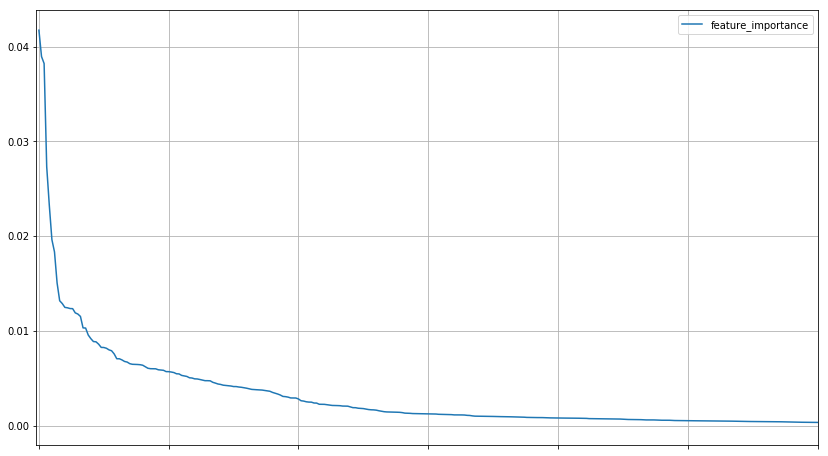

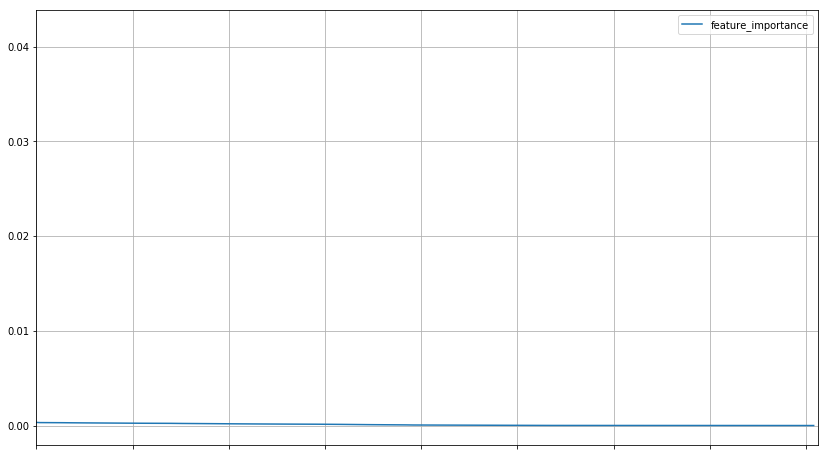

In [567]:
num = 300
imp.plot(figsize=(14,8), grid=True, xlim=(-1,num))
imp.plot(figsize=(14,8), grid=True, xlim=(num,len(x_data_train.columns)))

In [568]:
x_data_t = x_data_con[imp.index[:num]]
rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_depth=28)
rf.fit(x_data_t, is_mal_con)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [569]:
print(rf.score(x_data_bonsun1[imp.index[:num]], is_mal_bonsun1))

0.9517886626307099


In [570]:
x_data_con = x_data_con[imp.index[:num]]
x_data_bonsun1 = x_data_bonsun1[imp.index[:num]]

In [652]:
x_data_bonsun1 = x_data_bonsun1[imp.index[:num]]

In [435]:
# RANDOMFOREST
import numpy as np
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [60,70,80,90,100] #40,50
#int(x) for x in np.linspace(10, 30, num = 3)
# Minimum number of samples required to split a node
min_samples_split = [2] #10 

# Minimum number of samples required at each leaf node
min_samples_leaf = [1] #4


# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Create a based model
clf = RandomForestClassifier()

# Instantiate the grid search model
grid_search2 = GridSearchCV(estimator = clf, param_grid = param_grid,scoring='accuracy',
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search2.fit(x_data_con, is_mal_con)

print(grid_search2.best_params_)
best_grid = grid_search2.best_estimator_
grid_search2.best_score_ #0.947

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  4.1min finished


{'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


0.95825

In [436]:
best_grid

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
x_data_bonsun1 = x_data_

In [360]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, colsample_bytreeb=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=-1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [582]:
xgb.fit(x_data_con, y_data_con)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, colsample_bytreeb=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=1, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [583]:
light_gbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.009, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_split_gain=0.0, n_estimators=1400, n_jobs=-1, num_leaves=90,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [585]:
light_gbm.fit(x_data_con, y_data_con)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.009, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_split_gain=0.0, n_estimators=1400, n_jobs=-1, num_leaves=90,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [586]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [587]:
rf.fit(x_data_con, y_data_con)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [653]:
rf.score(x_data_bonsun1, is_mal_bonsun1)

0.9517886626307099

In [ ]:
rf.score(x_data_bonsun1, is_mal_bonsun1)

In [657]:
print(classification_report(y_true=is_mal_bonsun1, y_pred=rf.predict(x_data_bonsun1)))

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      2666
         1.0       0.96      0.97      0.97      6419

   micro avg       0.95      0.95      0.95      9085
   macro avg       0.94      0.94      0.94      9085
weighted avg       0.95      0.95      0.95      9085



In [441]:
t = pd.DataFrame(oof_test_rf.reshape(-1,), columns=['pred'])

In [443]:
t['real'] = is_mal_bonsun1

In [ ]:
## model

###### model 1

rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_depth=28, bootstrap=True)

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, colsample_bytreeb=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=900, n_jobs = -1,
       nthread=1, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

extree =  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=40, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

lightgb = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.65, learning_rate=0.005,
                        n_estimators=1400, num_leaves=90, objective='binary',
                        rnadom_state=501, reg_alpha=1, reg_lambda=1, subsample=0.7)

catboost = cb.CatBoostClassifier(depth=7, iterations=600, learning_rate=0.15, l2_leaf_reg=1)

tree = DecisionTreeClassifier(criterion='entropy', max_depth=28, random_state=0)

oof_train_xgb, oof_test_xgb = get_oof(xgb, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

oof_train_rf, oof_test_rf = get_oof(rf, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

oof_train_tree, oof_test_tree = get_oof(tree, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

oof_train_extree, oof_test_extree = get_oof(extree, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

oof_train_lgb, oof_test_lgb = get_oof(lightgb, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

oof_train_cb, oof_test_cb = get_oof(catboost, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

x_train = np.concatenate((oof_train_rf, oof_train_extree, oof_train_lgb, oof_train_cb), axis = 1)
x_train = pd.DataFrame(x_train)

x_test = np.concatenate((oof_test_rf, oof_test_extree, oof_test_lgb, oof_test_cb), axis = 1)
x_test = pd.DataFrame(x_test)

x_train = np.concatenate((oof_train_rf, oof_train_extree, oof_train_tree), axis = 1)
x_train = pd.DataFrame(x_train)

x_test = np.concatenate((oof_test_rf, oof_test_extree, oof_test_tree), axis = 1)
x_test = pd.DataFrame(x_test)

x_train.columns = ['rf', 'extree', 'lgb', 'cb']
x_test.columns = ['rf', 'extree', 'lgb', 'cb']

x_train.columns = ['rf', 'extree', 'tree']
x_test.columns = ['rf', 'extree', 'tree']

rf_l2 = RandomForestClassifier(n_estimators=300, random_state=None, max_depth=3, n_jobs=-1, max_features=2)

rf_l2.fit(x_train, is_mal_train_yesun)

print("훈련 세트 정확도: {:.3f}".format(rf_l2.score(x_train, is_mal_train_yesun)))
# print("테스트 세트 정확도: {:.3f}".format(rf_l2.score(x_test, is_mal_yesun)))

rf_l2.predict(x_test)

extree_l2 =  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=3, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

extree_l2.fit(x_train, is_mal_train_yesun)

print("훈련 세트 정확도: {:.3f}".format(extree_l2.score(x_train, is_mal_train_yesun)))
# print("테스트 세트 정확도: {:.3f}".format(extree_l2.score(x_test, is_mal_yesun)))

lightgb_l2 = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.65, learning_rate=0.005,
                        n_estimators=300, num_leaves=90, objective='binary',
                        rnadom_state=501, reg_alpha=1, reg_lambda=1, subsample=0.7)

lightgb_l2.fit(x_train, is_mal_train_yesun)

print("훈련 세트 정확도: {:.3f}".format(lightgb_l2.score(x_train, is_mal_train_yesun)))
# print("테스트 세트 정확도: {:.3f}".format(lightgb_l2.score(x_test, is_mal_yesun)))

t = pd.DataFrame()
t['pred'] = list(oof_test_lgb.reshape(-1,))
t['pred'] = rf_l2.predict(x_test)

t['real'] = is_mal_yesun

len(t[t.pred == t.real])

# 테스트

rf.fit(x_data_train, is_mal_train)

rf.score(x_data_yesun, is_mal_yesun)

x_data_yesun['is_mal'] = is_mal_yesun
x_data_yesun['predict_mal'] = rf.predict(x_data_yesun.drop(['is_mal'], axis = 1))

x_data_yesun[x_data_yesun.is_mal != x_data_yesun.predict_mal].to_csv('./test.csv')

###### 본선용

x_data_bonsun = pd.read_csv('./data_bonsun1.csv')

label = x_data_bonsun['hash'].to_frame()
x_data_bonsun = x_data_bonsun.drop(['hash'], axis = 1)

label['predict_mal'] = rf_l2.predict(x_test)

rf_l2.score(x_train, is_mal_train_yesun)

label.to_csv('./submission.csv')


a1 = pd.read_csv('./result_malware_student_songwonho_third.csv')#, encoding = "ISO-8859-1")
a2 = pd.read_csv('./result_malware_student_songwonho_first.csv')#, encoding = "ISO-8859-1")
a3 = pd.read_csv('./result_malware_student_songwonho_second.csv')#, encoding = "ISO-8859-1")
a4 = pd.read_csv('./submission.csv')

a4["first"] = a2.iloc[:,1]

a4["second"] = a3.iloc[:,1]

a4["third"] = a1.iloc[:,1]

a4.columns = ['hash', 'predict', 'first', 'second', '']

a1[a1.second == a1.first]

a4.to_csv('test.csv')



In [588]:
###### 본선용

x_data_bonsun2 = pd.read_csv('./data_bonsun2.csv')

label = x_data_bonsun2['hash'].to_frame()
x_data_bonsun2 = x_data_bonsun2.drop(['hash'], axis = 1)
x_data_bonsun2 = x_data_bonsun2[imp.index[:num]]

label['xgb'] = xgb.predict(x_data_bonsun2)
label['lgb'] = light_gbm.predict(x_data_bonsun2)
label['rf'] = light_gbm.predict(x_data_bonsun2)

In [618]:
a = label.iloc[:,1:]

In [593]:
from collections import Counter

In [640]:
a.to_csv('./ashewoyo.csv')

In [646]:
a['pred'] = a['xgb']

In [648]:
a.pred.to_frame()

,pred
0,1
1,1
2,0
3,1
4,0
5,1
6,1
7,0
8,1
9,0


In [ ]:
rf_l2 = RandomForestClassifier(n_estimators=300, random_state=None, max_depth=3, n_jobs=-1, max_features=2)

rf_l2.fit(label.drop['hash'], is_mal_train_yesun)

In [371]:
xgb.score(x_data_bonsun1, is_mal_bonsun1)

0.960044028618602

In [372]:
label = label.set_index('hash')

In [373]:
label.to_csv('./submission.csv')

In [ ]:


a1 = pd.read_csv('./result_malware_student_songwonho_third.csv')#, encoding = "ISO-8859-1")
a2 = pd.read_csv('./result_malware_student_songwonho_first.csv')#, encoding = "ISO-8859-1")
a3 = pd.read_csv('./result_malware_student_songwonho_second.csv')#, encoding = "ISO-8859-1")
a4 = pd.read_csv('./submission.csv')

a4["first"] = a2.iloc[:,1]

a4["second"] = a3.iloc[:,1]

a4["third"] = a1.iloc[:,1]

a4.columns = ['hash', 'predict', 'first', 'second', '']

a1[a1.second == a1.first]

a4.to_csv('test.csv')

In [90]:
mal = pd.read_csv('../DataChallenge/bonsun1_malware.csv')
be = pd.read_csv('../DataChallenge/bonsun1_benign.csv')

In [91]:
bonsun_1 = pd.read_csv('../DataChallenge_/data_bonsun1.csv')

In [92]:
mal = pd.merge(mal, bonsun_1, on='hash', how='left')
be = pd.merge(be, bonsun_1, on='hash', how='left')


In [95]:
bonsun_1 = pd.concat([mal, be]).sort_values('hash')

In [97]:
bonsun_1 = bonsun_1.set_index('hash')

In [102]:
bonsun_1.is_mal.to_frame().to_csv('./result_bonsun_1/label.csv')

In [105]:
bonsun_1.iloc[:,1:].to_csv('./data_bonsun1.csv')